In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from collections import Counter
import missingno as msno
train, test = train_test_split(df, test_size=0.2)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [2]:
df=pd.read_csv('E:\\internship\\Footballer.csv')

In [3]:
#DROP UNNECESSARY VALUES
drop_cols = df.columns[28:54]
df = df.drop(drop_cols, axis = 1)
df = df.drop(['Unnamed: 0','ID','Photo','Flag','Club Logo','Jersey Number','Joined','Special','Loaned From','Body Type', 'Release Clause',
               'Weight','Height','Contract Valid Until','Wage','Value','Name','Club'], axis = 1)
df = df.dropna()
df.head()

,Age,Nationality,Overall,Potential,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Real Face,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,Argentina,94,94,Left,5.0,4.0,4.0,Medium/ Medium,Yes,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,Portugal,94,94,Right,5.0,4.0,5.0,High/ Low,Yes,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,Brazil,92,93,Right,5.0,5.0,5.0,High/ Medium,Yes,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,Spain,91,93,Right,4.0,3.0,1.0,Medium/ Medium,Yes,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,Belgium,91,92,Right,4.0,5.0,4.0,High/ High,Yes,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [4]:
#Turn Real Face into a binary indicator variable
def face_to_num(df):
    if (df['Real Face'] == 'Yes'):
        return 1
    else:
        return 0
    
#Turn Preferred Foot into a binary indicator variable
def right_footed(df):
    if (df['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0

#Create a simplified position varaible to account for all player positions
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 'DF'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 'DM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return 'MF'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 'ST'
    else:
        return df.Position

#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)
nat_counts = df.Nationality.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df):
    if (df.Nationality in nat_list):
        return 1
    else:
        return 0

#Create a copy of the original dataframe to avoid indexing errors
df1 = df.copy()

#Apply changes to dataset to create new column
df1['Real_Face'] = df1.apply(face_to_num, axis=1)
df1['Right_Foot'] = df1.apply(right_footed, axis=1)
df1['Simple_Position'] = df1.apply(simple_position,axis = 1)
df1['Major_Nation'] = df1.apply(major_nation,axis = 1)

#Split the Work Rate Column in two
tempwork = df1["Work Rate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
df1["WorkRate1"]= tempwork[0]   
#Create new column for second work rate
df1["WorkRate2"]= tempwork[1]
#Drop original columns used
df1 = df1.drop(['Work Rate','Preferred Foot','Real Face', 'Position','Nationality'], axis = 1)
df1.head()

,Age,Overall,Potential,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,GKHandling,GKKicking,GKPositioning,GKReflexes,Real_Face,Right_Foot,Simple_Position,Major_Nation,WorkRate1,WorkRate2
0,31,94,94,5.0,4.0,4.0,84.0,95.0,70.0,90.0,...,11.0,15.0,14.0,8.0,1,0,ST,1,Medium,Medium
1,33,94,94,5.0,4.0,5.0,84.0,94.0,89.0,81.0,...,11.0,15.0,14.0,11.0,1,1,ST,1,High,Low
2,26,92,93,5.0,5.0,5.0,79.0,87.0,62.0,84.0,...,9.0,15.0,15.0,11.0,1,1,AM,1,High,Medium
3,27,91,93,4.0,3.0,1.0,17.0,13.0,21.0,50.0,...,85.0,87.0,88.0,94.0,1,1,GK,1,Medium,Medium
4,27,91,92,4.0,5.0,4.0,93.0,82.0,55.0,92.0,...,13.0,5.0,10.0,13.0,1,1,MF,1,High,High


In [6]:
#Split ID as a Target value
target = df1.Overall
df2 = df1.drop(['Overall'], axis = 1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.2)

#One Hot Encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(3630, 54) (14517, 54)
(3630,) (14517,)


In [7]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Finding the r2 score and root mean squared error
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: '+str(r2_score(y_test, predictions)))
print('RMSE : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

r2 score: 0.9264126968698168
RMSE : 1.8305442106585337


In [10]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
#Top 3 important features are Potential, Age & Reactions 

Weight,Feature
0.3835 ± 0.0134,Potential
0.2063 ± 0.0118,Age
0.0763 ± 0.0045,Reactions
0.0586 ± 0.0013,BallControl
0.0450 ± 0.0017,GKReflexes
0.0323 ± 0.0021,GKDiving
0.0252 ± 0.0015,HeadingAccuracy
0.0208 ± 0.0015,ShortPassing
0.0197 ± 0.0014,GKHandling
0.0143 ± 0.0018,Skill Moves


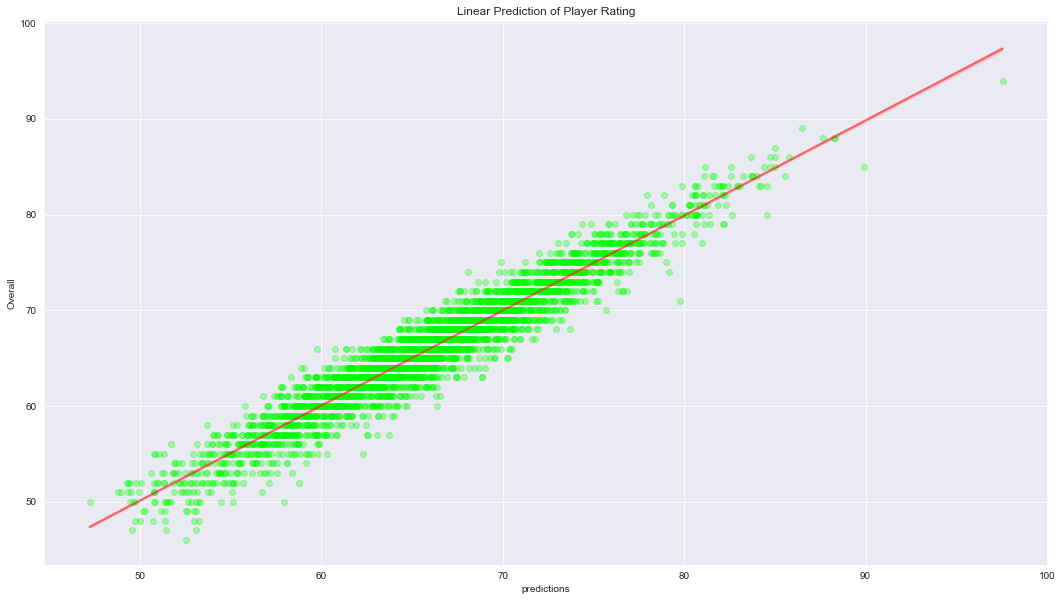

In [28]:
#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_test,scatter_kws={'alpha':0.3,'color':'lime'},line_kws={'color':'red','alpha':0.5})
plt.xlabel('predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

In [29]:
# to predict the overall
coefs = model.coef_

In [30]:
josef = test.iloc[6]
josef_stats = josef[['Acceleration','Balance','Reactions','Positioning','Skill Moves','BallControl','Crossing','Finishing']]

In [31]:
speed = [a*b for a,b in zip(coefs,josef_stats)]
sum(speed)+model.intercept_

94.2206084886623